In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng, SeedSequence
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

sq = SeedSequence()
seed = sq.entropy
rng = default_rng(sq)

### Tools

In [2]:
def brownian_1d(n_times: int, n_paths: int, 
                final_time: float=1.0, 
                increments: bool=False, 
                random_state: np.random.Generator=rng) -> np.array:
    """Simulate paths of standard Brownian motion
    Args:
        n_times: Number of timesteps
        n_paths: Number of paths 
        final_time: Final time of simulation
        increments: If `True` the increments of the paths are returned.
        random_state: `np.random.Generator` used for simulation
    Returns:
        `np.array` of shape `(n_times+1, n_paths)` containing the paths if the argument `increments` is `False`
        `np.array` of shape `(n_times, n_paths)` containing the increments if the argument `increments` is `True`
    """
    dB = np.sqrt(final_time / n_times) * random_state.standard_normal((n_times, n_paths))
    if increments:
        return dB
    else:
        brownian = np.zeros((n_times+1, n_paths))
        brownian[1:] = np.cumsum(dB, axis=0)
        return brownian

In [3]:
def black_scholes_1d(n_times: int, n_paths: int, 
                     final_time: float=1.0, 
                     random_state: np.random.Generator=rng, *,
                     init_value: float,
                     r: float, sigma: float) -> np.array:
    """Simulate paths of Black-Scholes process
    Args:
        n_times: Number of timesteps
        n_paths: Number of paths 
        final_time: Final time of simulation
        init_value: `S0`
        r: Interest rate
        sigma: Volatility
        random_state: `np.random.Generator` used for simulation
    Returns:
        `np.array` of shape `(n_times+1, n_paths)` containing the paths 
    """
    Bt = brownian_1d(n_times, n_paths)
    times = np.arange(n_times+1)*(1/n_times)
    t = times[:, np.newaxis]
    St = init_value * np.exp((r - 0.5*sigma**2)*t + sigma*Bt)
    return St

In [4]:
# une fonction BS pour un payoff qui n'est pas path-dependent (offre plus de liberté pour le choix des gaussiennes dans la fonction)
def BS(x,r,sigma,T,N):
    """ args :
            x=spot
            r=interest rate
            sigma=volatility
            T=maturity
            N=simulated standard normal random variable
    """
    return  x*np.exp((r-(sigma**2)/2)*T+sigma*np.sqrt(T)*N)

# une fonction de payoff du call et sa dérivée par rapport à S_T
def payoff_call(S,r,T,K): return np.exp(-r*T)*np.maximum(S-K,0)
def payoff_put(S,r,T,K): return np.exp(-r*T)*np.maximum(K-S,0)

def call_derive(S,r,T,K): return np.exp(-r*T)*np.where(S>K,1,0)

In [5]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    return (mean, var, mean - ci_size, mean + ci_size)

In [6]:
# Les formules fermées de Black-Scholes pour vérifier nos méthodes de MC

def d1(spot, t, r, sigma, strike):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r, sigma, strike):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r, sigma, strike):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def delta_BS(spot, t, r, sigma, strike):
    d1_ = d1(spot, t, r, sigma, strike)
    return norm.cdf(d1_)

### Standard MC

In [7]:
# Fixons les paramètres

S0 = 100
T=1
K=100
r, sigma = 0.04, 0.20

In [8]:
Ms = 10**np.arange(3, 8)
results = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    gaussiennes = rng.standard_normal(M)
    payoffs=payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)
    results[M] = monte_carlo(payoffs)
results

,1000,10000,100000,1000000,10000000
Mean,9.712122,10.042327,9.886496,9.926891,9.926359
Var,189.080850,207.154298,206.833680,208.259954,207.870333
Lower,8.859863,9.760233,9.797359,9.898607,9.917422
Upper,10.564382,10.324422,9.975634,9.955176,9.935295


In [9]:
price_call_BS(S0, T, r, sigma, K)

9.925053717274437

# Importance Sampling

We want to estimate :
$$
e^{-rT}\mathbb E(\Phi(X_T^x))=\mathbb E(h(Z))
$$
where $\Phi$ is the payoff function and $Z \sim \mathcal N(0,1)$.

Importance sampling method : lets introduce $Y_\theta := Z+\theta$ with pdf $f_\theta$ and we estimate :
$$
\mathbb E(\frac{h(Y_\theta)\mathcal N(Y_\theta)}{f_\theta(Y_\theta)})=e^\frac{\theta^2}{2} \mathbb E(h(Y_\theta)e^{-\theta Y_\theta})
$$

For a standard call, when x<<K (deep OTM), most of the simulations of $h(Z)$ yield zero.

Objective : recenter simulations of $X_T^x$ around the strike replacing $Z$ by $Z+\theta_0$ and let's look for $\theta_0$ which minimizes variance.

In [38]:
# Fixons les paramètres (paramètres OTM)
S0 = 80
T=1
K=100
r, sigma = 0.04, 0.20

In [39]:
# on choisit le payoff Phi comme étant le payoff d'un call standard
def h(z):
    ST=S0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*z)
    return payoff_call(ST,r,T,K)

In [40]:
def var_theta(theta) :
    M=10**6
    results = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'])
    gaussiennes = rng.standard_normal(M)
    payoffs=np.exp(0.5*theta**2)*h(gaussiennes+theta)*np.exp(-theta*(gaussiennes+theta))
    results[M] = monte_carlo(payoffs)
    return results

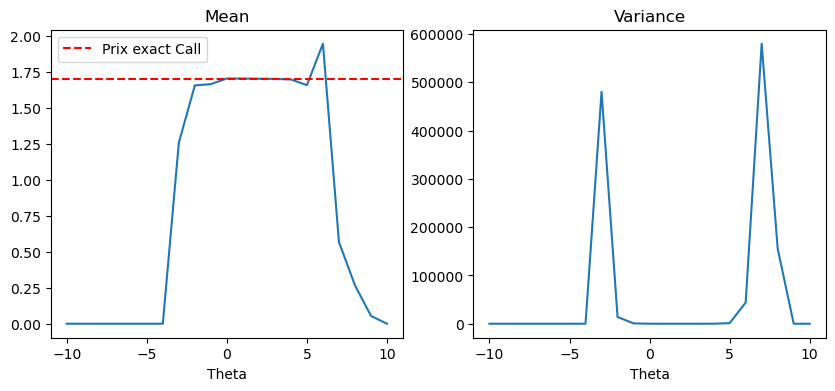

In [41]:
fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

Theta=np.arange(-10,11)
mean=[]
variance=[]
for theta in Theta:
    mean.append(var_theta(theta).iloc[0,0])
    variance.append(var_theta(theta).iloc[1,0])
    

ax1.plot(Theta, mean)
ax1.axhline(y=price_call_BS(spot=S0, t=T, r=r, sigma=sigma, strike=K), color='r', linestyle='--', label='Prix exact Call')
ax1.legend()
ax1.set_xlabel('Theta')
ax1.set_title('Mean')

ax2.plot(Theta, variance)
ax2.set_xlabel('Theta')
ax2.set_title('Variance')

plt.show()

By knowing the exact price from the closed-form formula, we observe that the search domain for $\theta$ that minimizes the variance is within the range (-1, 5), as this $\theta$ must ensure the stability of the simulation and the proper convergence of the price. We also note that this is indeed a range where we can look for the $\theta$ that minimizes the variance, as the graph on the right shows that the variance is low within this range.

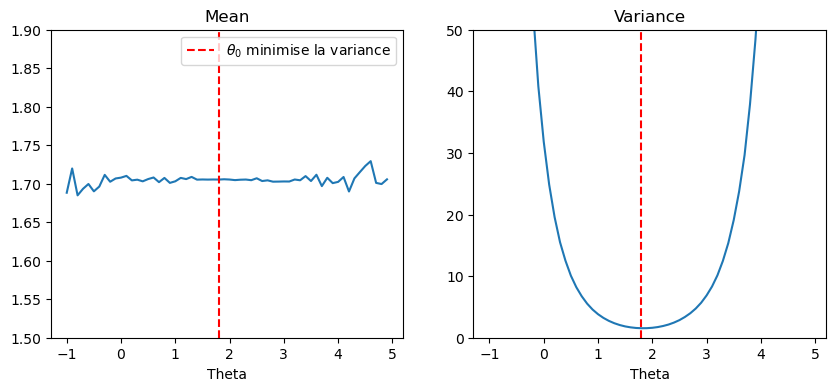

In [42]:
fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
Theta=np.arange(-1,5,0.1)
mean=[]
variance=[]
for theta in Theta:
    mean.append(var_theta(theta).iloc[0,0])
    variance.append(var_theta(theta).iloc[1,0])

theta0=Theta[np.argmin(variance)]

ax1.plot(Theta, mean)
ax1.axvline(x=theta0, color='r', linestyle='--', label=r'$\theta_0$ minimise la variance')
ax1.set_ylim(1.5,1.9)
ax1.set_xlabel('Theta')
ax1.set_title('Mean')
ax1.legend()

ax2.plot(Theta, variance)
ax2.axvline(x=theta0, color='r', linestyle='--')
ax2.set_ylim(0,50)
ax2.set_xlabel('Theta')
ax2.set_title('Variance')


plt.show()

We can now apply the MC methods and compare the variances.

In [43]:
# sans réduction

Ms = 10**np.arange(3, 8)
results = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    gaussiennes = rng.standard_normal(M)
    payoffs=payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)
    results[M] = monte_carlo(payoffs)
results

,1000,10000,100000,1000000,10000000
Mean,2.087005,1.827168,1.705550,1.703937,1.703784
Var,39.511990,33.696724,31.464542,31.690195,31.738966
Lower,1.697411,1.713394,1.670784,1.692904,1.700292
Upper,2.476600,1.940941,1.740317,1.714970,1.707276


In [44]:
# échantillonnage préférentiel

Ms = 10**np.arange(3, 8)
results = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    Y = rng.standard_normal(M)+theta0
    payoffs=payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=Y),r=r,T=T,K=K)*np.exp(-theta0*Y)*np.exp(0.5*theta0**2)
    results[M] = monte_carlo(payoffs)
results

,1000,10000,100000,1000000,10000000
Mean,1.631183,1.709792,1.705068,1.706215,1.705902
Var,1.528551,1.516178,1.544139,1.542228,1.541173
Lower,1.554555,1.685658,1.697366,1.703781,1.705132
Upper,1.707811,1.733925,1.712769,1.708649,1.706671


Important variance reduction observed